In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [7]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


2023-06-13 20:20:40.178925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 20:20:40.178958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-13 20:20:40.179100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 20:20:40.179112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
columns = ['Model Name','Number of Params','Accuracy','Recall','Precision','F1_score']
resultat_df = pd.DataFrame(columns = columns)
resultat_df

,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score


In [9]:
train_df = pd.read_csv('Dataframe/train_df.csv')
test_df = pd.read_csv('Dataframe/test_df.csv')

print('train_df shape =', train_df.shape)
print('test_df shape =', test_df.shape)

train_df shape = (13673, 2)
test_df shape = (3419, 2)


## Modelisation

In [11]:
#méthodes décrites ici : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe

datagen_train = ImageDataGenerator(rescale = None, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = None)

batch_size = 32
height  = 360
width = 363
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='Path',
    y_col='target',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='Path',
    y_col='target',
    target_size=(360, 363),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None, 
    x_col='Path',
    y_col='target',
    target_size=(360, 363),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical', 
    batch_size = batch_size, 
    shuffle = False)

nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples
label_map = train_set.class_indices


print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 10939 validated image filenames belonging to 8 classes.
Found 2734 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 10939 images appartenant à 8 classes
le dataframe validation est composé de 2734 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


In [12]:
#benchmark entrainement avec le modèle proposé dans le tutorial tensorflow : https://www.tensorflow.org/tutorials/images/classification?hl=fr

num_classes = len(train_set.class_indices)

model_benchmark = Sequential([
  layers.Rescaling(1./255, input_shape=(height, width, color)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

2023-06-13 20:21:11.205297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 20:21:11.205337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
#Compiler le modèle
model_benchmark.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [14]:
#Résumé du modème
model_benchmark.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 360, 363, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 363, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 181, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 181, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        1

In [19]:
#mise en place de callbacks
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', #métrique à controller
                                         min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, que ce soit à la hausse ou à la baisse, on arrête au bout de 5 épochs
                                         patience=10,
                                         verbose = 0,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', #métrique à controller
                                         factor=0.1, #factor by which the learning rate will be reduced. new_lr = lr * factor.
                                         patience=5, #number of epochs with no improvement after which learning rate will be reduced.
                                         verbose=0,
                                         mode='min')

In [20]:
#Entrainement du modèle
epochs=100
history_benchmark = model_benchmark.fit(
  train_set,
  validation_data=validation_set,
  steps_per_epoch = nb_img_train//batch_size,
  validation_steps = nb_img_val//batch_size,
  epochs=epochs,
  callbacks = [early_stopping, lr_plateau]
)

Epoch 1/100
341/341 [==============================] - 91s 266ms/step - loss: 0.1140 - accuracy: 0.9630 - val_loss: 0.2727 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 2/100
341/341 [==============================] - 92s 269ms/step - loss: 0.0979 - accuracy: 0.9662 - val_loss: 0.3145 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 3/100
341/341 [==============================] - 99s 291ms/step - loss: 0.0555 - accuracy: 0.9822 - val_loss: 0.3499 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 4/100
341/341 [==============================] - 104s 304ms/step - loss: 0.0391 - accuracy: 0.9884 - val_loss: 0.2634 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 5/100
341/341 [==============================] - 109s 318ms/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.2971 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 6/100
341/341 [==============================] - 117s 342ms/step - loss: 0.0937 - accuracy: 0.9694 - val_loss: 0.2472 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 7/100
341/341 [======================

In [21]:
#sauvegarde des performances benchmark
train_acc_benchmark = history_benchmark.history['accuracy']
val_acc_benchmark = history_benchmark.history['val_accuracy']
train_loss_benchmark = history_benchmark.history['loss']
val_loss_benchmark = history_benchmark.history['val_loss']

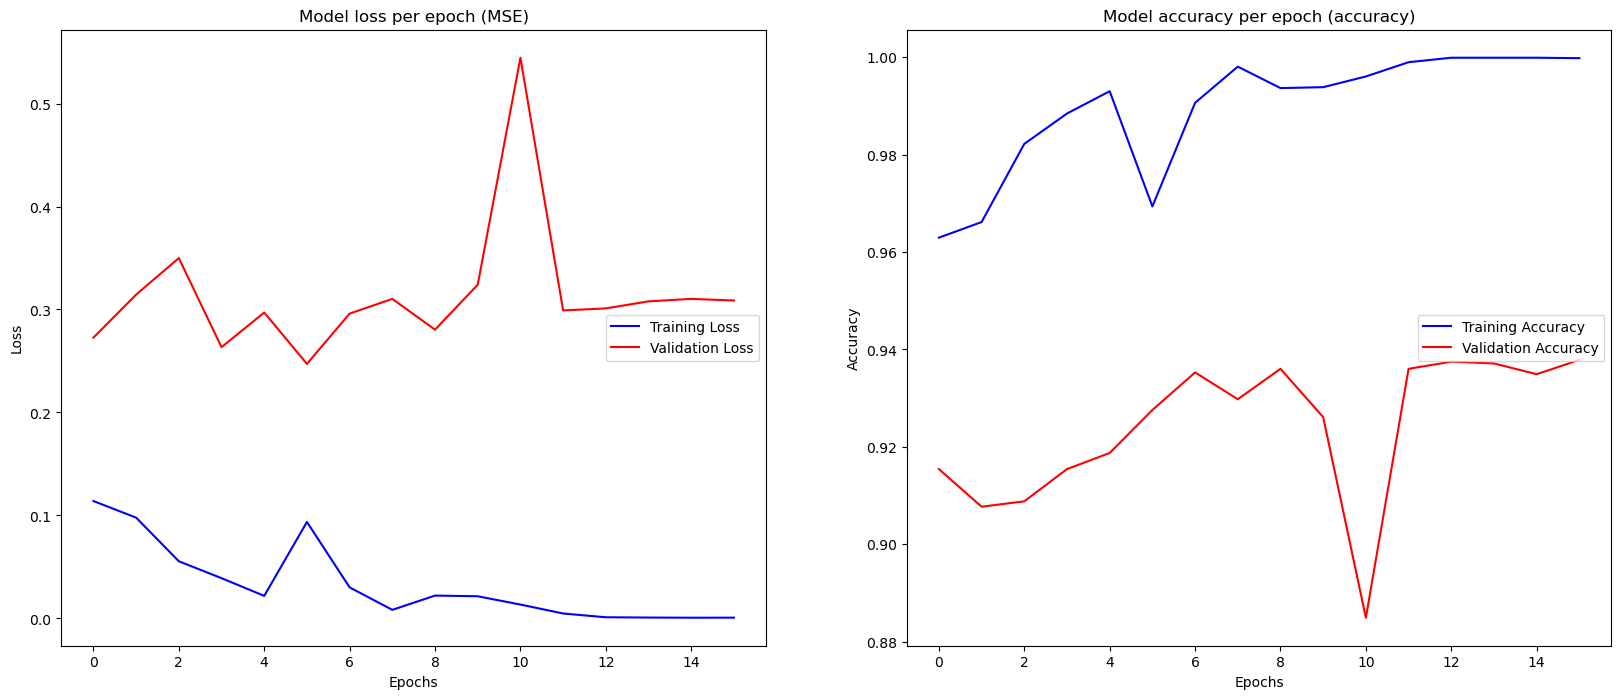

In [22]:
#visualisation des performances
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss_benchmark, label = 'Training Loss', color = 'blue')
plt.plot(val_loss_benchmark, label = 'Validation Loss', color = 'red')
plt.title('Model loss per epoch (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.subplot(122)
plt.plot(train_acc_benchmark, label = 'Training Accuracy', color = 'blue')
plt.plot(val_acc_benchmark, label = 'Validation Accuracy', color = 'red')
plt.title('Model accuracy per epoch (accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.show()

In [16]:
#Prediction
predictions_benchmark = model_benchmark.predict(test_set)
y_pred_benchmark = tf.argmax(predictions_benchmark, axis = 1)

2023-06-13 20:21:55.596948: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-13 20:21:55.661382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 10s 85ms/step


In [17]:
#Création d'une Matrice de confusion
def plot_matrix(y_true, y_pred, label):
  cm = confusion_matrix(y_true.classes, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
  print('Vous retrouverez la matrice de confusion du modèle ci-dessous:')
  plt.figure()
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  print('\nVous retrouverez le rapport de classification du modèle ci-dessous:\n')
  print(classification_report(y_true.classes, y_pred, target_names=label))

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

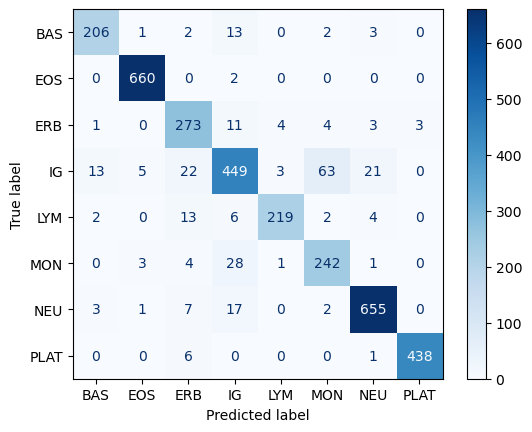


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

         BAS       0.92      0.91      0.91       227
         EOS       0.99      1.00      0.99       662
         ERB       0.83      0.91      0.87       299
          IG       0.85      0.78      0.81       576
         LYM       0.96      0.89      0.93       246
         MON       0.77      0.87      0.81       279
         NEU       0.95      0.96      0.95       685
        PLAT       0.99      0.98      0.99       445

    accuracy                           0.92      3419
   macro avg       0.91      0.91      0.91      3419
weighted avg       0.92      0.92      0.92      3419



In [18]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark,label =label_map)

Certaines classes sont avec un modèle basique déjà très bien identifié comme : 
- Platelet
- Eosinophils
- Neutrophils
- Lymphocytes
- Erythroblasts

Je sauvegarde le modèle :

In [27]:
#save model
model_benchmark.save('Model/model_benchmark')

INFO:tensorflow:Assets written to: Model/model_benchmark/assets


INFO:tensorflow:Assets written to: Model/model_benchmark/assets


In [19]:
def ajout_dataframe(nom_model, y_true, y_pred, num_params, dataframe):
  accuracy= []
  recall =[]
  precision = []
  f1 = []

  model_names = nom_model
  accuracy.append(round(accuracy_score(y_true.classes, y_pred),4))
  recall.append(round(recall_score(y_true.classes, y_pred, average='macro'),4))
  precision.append(round(precision_score(y_true.classes, y_pred, average='macro'),4))
  f1.append(round(f1_score(y_true.classes, y_pred, average='macro'),4))

  result_model = {'Model Name': model_names,'Number of Params': num_params,'Accuracy':accuracy,'Recall':recall, 'Precision':precision, 'F1_score': f1}
  dataframe = dataframe.append(result_model, ignore_index=True)
  return dataframe

In [20]:
ajout_dataframe(nom_model = 'model_benchmark', y_true = test_set, y_pred = y_pred_benchmark, num_params = 16613544, dataframe = resultat_df)

,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score
0,model_benchmark,16613544,[0.919],[0.9119],[0.9084],[0.9092]


In [15]:
#loading model
model_benchmark = tf.keras.models.load_model('Model/model_benchmark')
model_benchmark.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 360, 363, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 363, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 181, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 181, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        1

## Interprétabilité

In [10]:
#création d'un dataframe pour l'interprétabilité 
mapping_dict = {value: key for key, value in label_map.items()}
df_interpretation = test_df.copy()

#Prediction
predictions_benchmark = model_benchmark.predict(test_set)
y_pred_benchmark = tf.argmax(predictions_benchmark, axis = 1)

#conversion
arr = np.array(y_pred_benchmark)
converted_arr = np.vectorize(mapping_dict.get)(arr)
df_interpretation['prediction'] = converted_arr
df_interpretation.head(10)

107/107 [==============================] - 9s 85ms/step


,Path,target,prediction
0,/Users/arthurnicolas/Desktop/Code/Projet DataS...,PLAT,PLAT
1,/Users/arthurnicolas/Desktop/Code/Projet DataS...,IG,IG
2,/Users/arthurnicolas/Desktop/Code/Projet DataS...,PLAT,PLAT
3,/Users/arthurnicolas/Desktop/Code/Projet DataS...,ERB,ERB
4,/Users/arthurnicolas/Desktop/Code/Projet DataS...,NEU,NEU
5,/Users/arthurnicolas/Desktop/Code/Projet DataS...,IG,IG
6,/Users/arthurnicolas/Desktop/Code/Projet DataS...,BAS,BAS
7,/Users/arthurnicolas/Desktop/Code/Projet DataS...,ERB,IG
8,/Users/arthurnicolas/Desktop/Code/Projet DataS...,IG,IG
9,/Users/arthurnicolas/Desktop/Code/Projet DataS...,NEU,NEU


In [11]:
def create_dict_explainer(df, model):
  from lime.lime_image import LimeImageExplainer

  category = list(df.target.unique()) #je renseigne les différentes catégories
  n = 2
  height  = 360
  width = 363
  dict_explainer = {}

  for i in category:
    df_new = df.loc[df['target'] == i] #je crée un dataframe reprenant uniquement la catégorie i
    df_new = df_new.loc[df_new['target'] == df_new['prediction']] #je loc sur target = image 
    df_new = df_new.sample(n=3) #je choisi 3 images aléatoires

    for j in range(n):
      image_path = df_new.iloc[j].Path
      img = tf.keras.utils.load_img(image_path, target_size=(height, width))
      numpy_image = np.array(img)
      numpy_image = numpy_image / 255

      explainer = LimeImageExplainer(verbose = False)
      explanation = explainer.explain_instance(image = numpy_image,
                                         classifier_fn = model.predict,
                                         top_labels = 1,
                                         num_samples = 1000)    
      # Store the object in the dictionary with a dynamic key
      key = f"explanation_{i}_{j}"
      dict_explainer[key] = explanation
  
  return dict_explainer

In [14]:
%%capture
dict_explainer_benchmark = create_dict_explainer(df_interpretation, model_benchmark)

In [15]:
def plot_explainer(dict_explainer):
  from skimage.segmentation import mark_boundaries
  for cle, objet in dict_explainer.items():
    print("Analyse LIME pour l'image {}".format(cle))
    temp_1, mask_1 = objet.get_image_and_mask(objet.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = objet.get_image_and_mask(objet.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(mark_boundaries(temp_1, mask_1))
    plt.title('SuperPixel pour cette catégorie')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(mark_boundaries(temp_2, mask_2))
    plt.title('Répartition des pixels positifs (vert) et négatifs (rouge)')
    plt.axis('off')
    plt.show()

Analyse LIME pour l'image explanation_PLAT_0


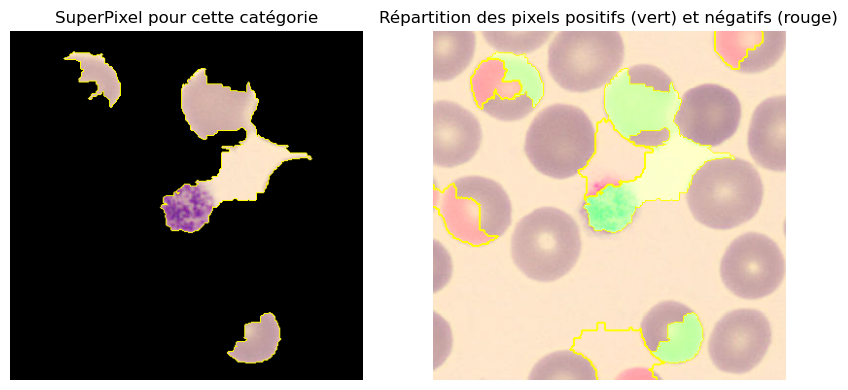

Analyse LIME pour l'image explanation_PLAT_1


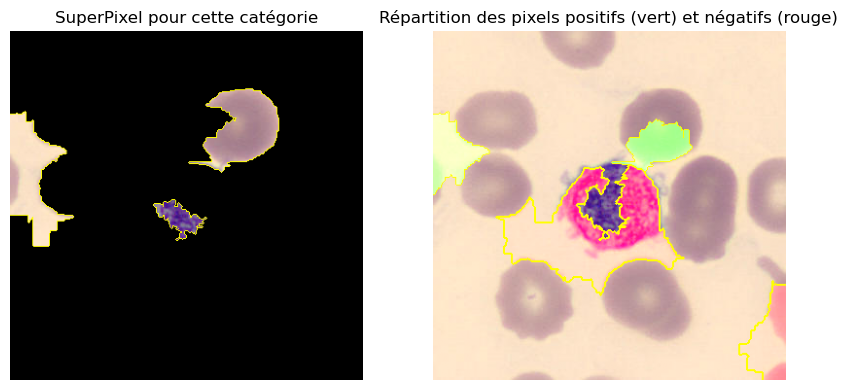

Analyse LIME pour l'image explanation_IG_0


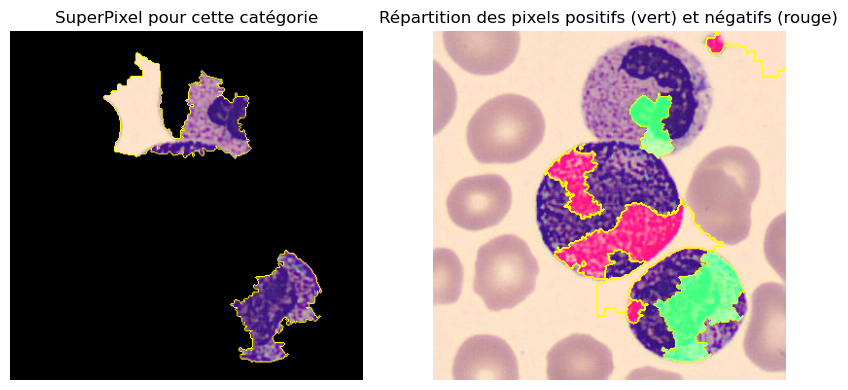

Analyse LIME pour l'image explanation_IG_1


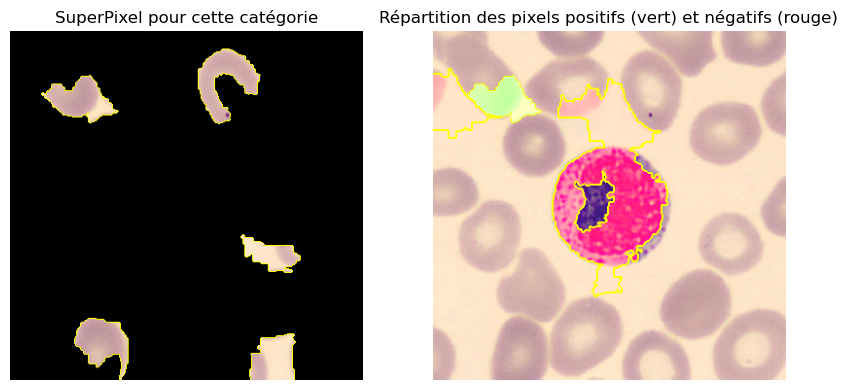

Analyse LIME pour l'image explanation_ERB_0


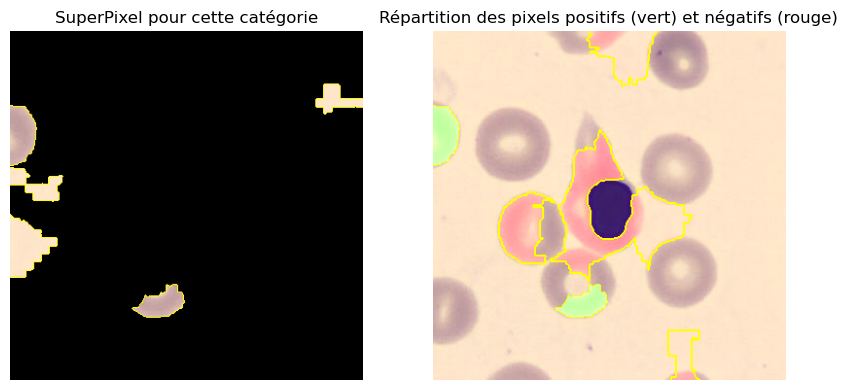

Analyse LIME pour l'image explanation_ERB_1


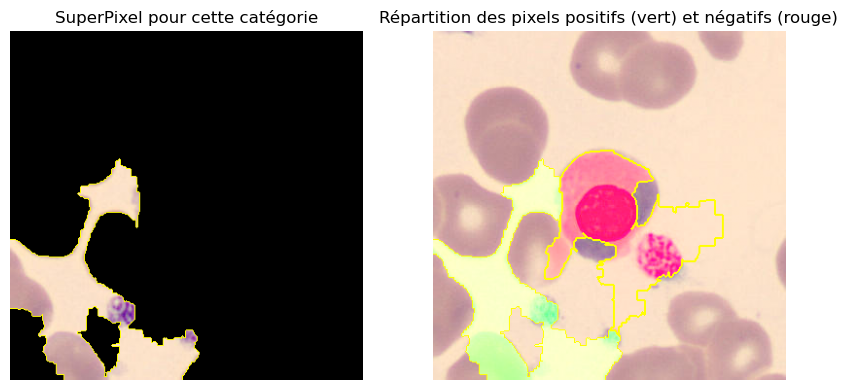

Analyse LIME pour l'image explanation_NEU_0


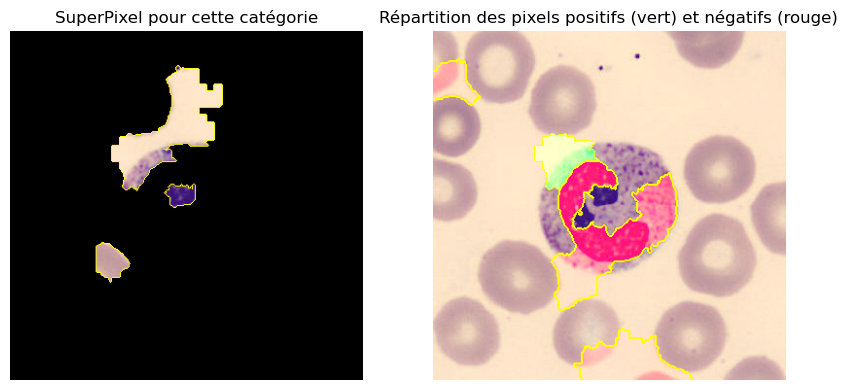

Analyse LIME pour l'image explanation_NEU_1


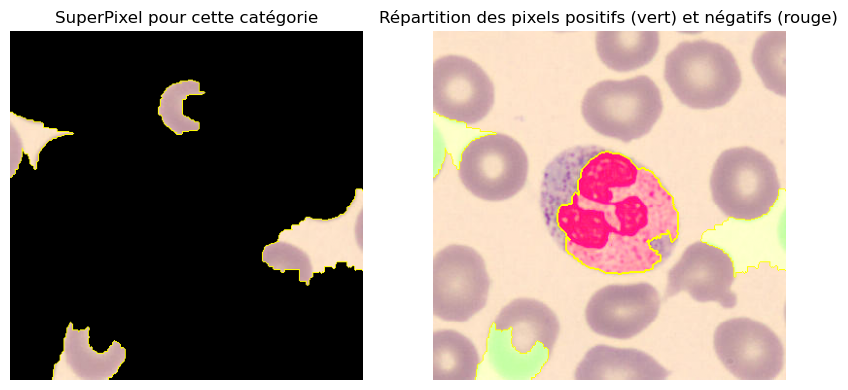

Analyse LIME pour l'image explanation_BAS_0


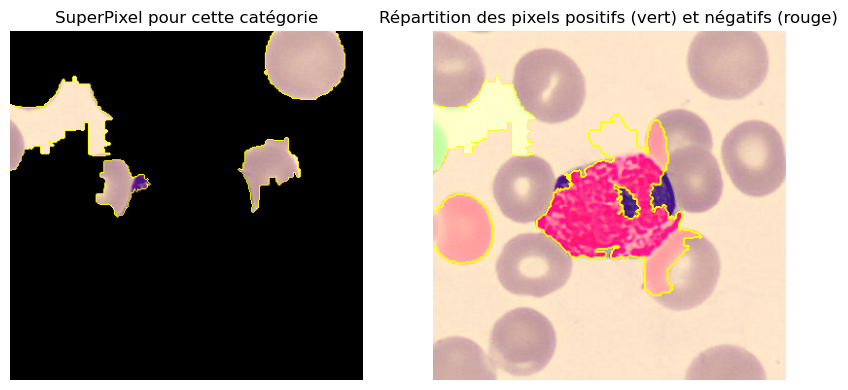

Analyse LIME pour l'image explanation_BAS_1


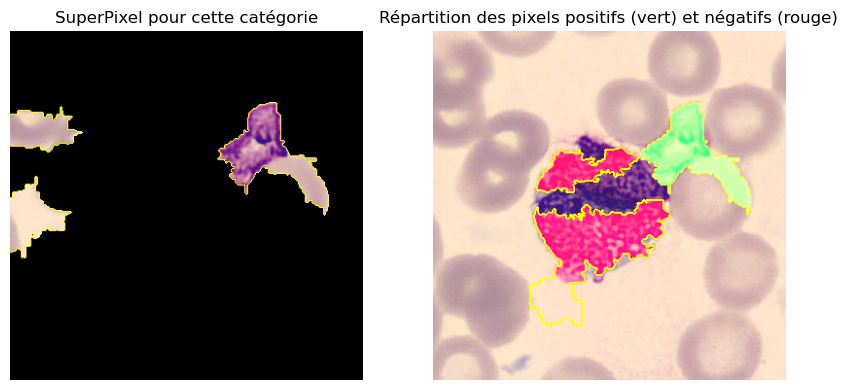

Analyse LIME pour l'image explanation_EOS_0


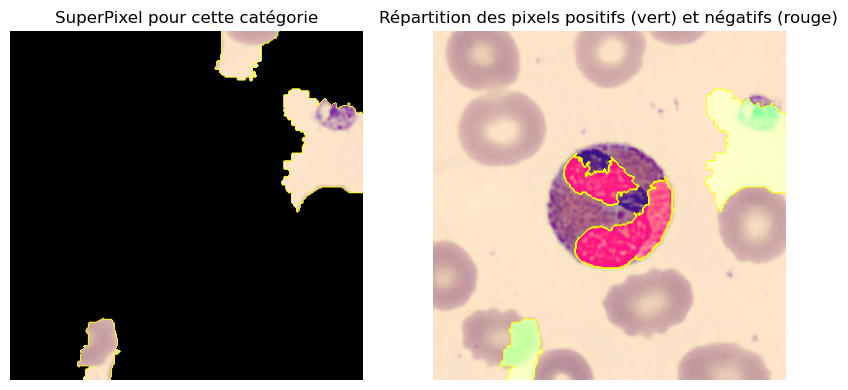

Analyse LIME pour l'image explanation_EOS_1


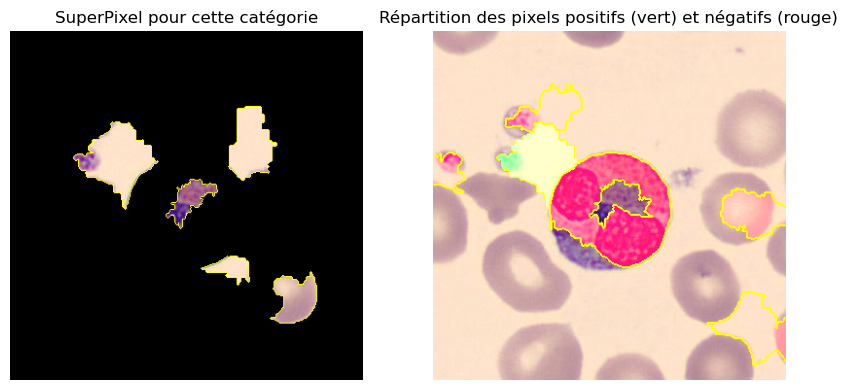

Analyse LIME pour l'image explanation_MON_0


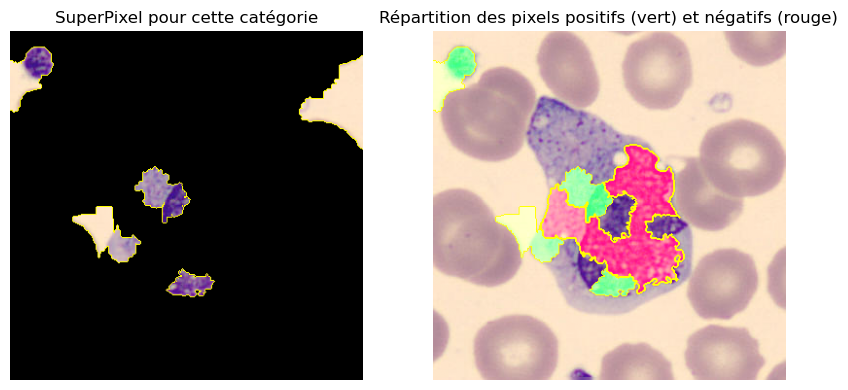

Analyse LIME pour l'image explanation_MON_1


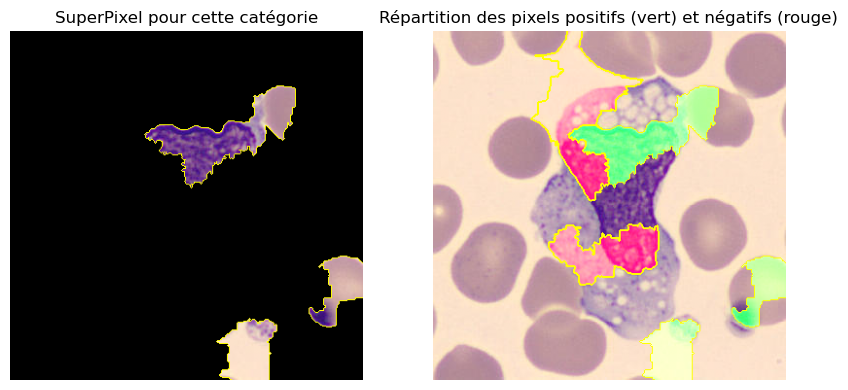

Analyse LIME pour l'image explanation_LYM_0


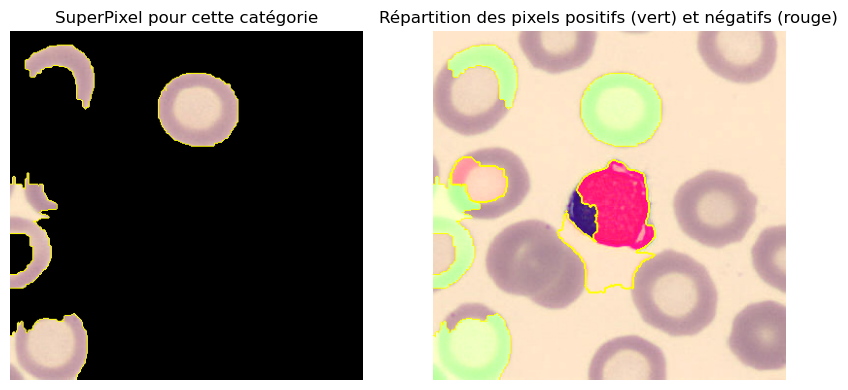

Analyse LIME pour l'image explanation_LYM_1


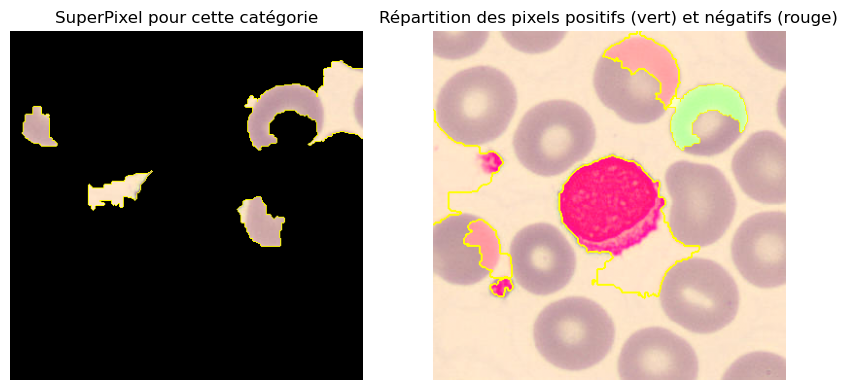

In [16]:
plot_explainer(dict_explainer_benchmark)